filtered data: https://jmcauley.ucsd.edu/data/googlelocal/kcore/

In [80]:
import gzip
from collections import defaultdict
import datetime
import dateutil
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random
import pandas as pd
import math

In [2]:
path = 'C:/Users/david/Documents/GitHub/CSE-158---CA-Google-Local-Predictions/'

In [3]:
def parseData(fname):
    for l in gzip.open(fname):
        d = eval(l)
        yield d

In [4]:
#filtering out users with <5 interactions
data_CA5 = list(parseData(path+"CA_5.json.gz"))

In [5]:
data_CA5[0]

{'rating': 4.0,
 'reviewerName': 'Mary Gainza',
 'reviewText': 'Gap always has a jean that fits awesomely, i wish their prices were a bit competitive in comparison to their outlets, also the amount of the pieces they have in store sometimes fly so quick that is hard to find an specific size with their best sellers, but in general i really like this store and most of their products.',
 'categories': ['Clothing Store',
  "Women's Clothing Store",
  "Children's Clothing Store"],
 'gPlusPlaceId': '100556368174926958612',
 'unixReviewTime': 1355436757,
 'reviewTime': 'Dec 13, 2012',
 'gPlusUserId': '100000715097692381911'}

In [6]:
# filtering out users with <10 interactions, subset of CA_5
# only users with 10 or more interactions
data_CA10 = list(parseData(path+'CA_10.json.gz'))

In [7]:
data_CA10[0]

{'rating': 4.0,
 'reviewerName': 'Rick Casady',
 'reviewText': None,
 'categories': ['Sushi Restaurant', 'Asian Restaurant', 'Japanese Restaurant'],
 'gPlusPlaceId': '100539657974695665920',
 'unixReviewTime': 1302881457,
 'reviewTime': 'Apr 15, 2011',
 'gPlusUserId': '100003840837471130074'}

In [8]:
places_CA = list(parseData(path+'places_CA.json.gz'))

In [10]:
print(len(data_CA5),len(data_CA10),len(places_CA))

163408 76967 171271


**EDA**<br />
1) distribution of reviews across time of day (David): **more or less done as of (11/25)**<br />
2) distribution across years/months (David): **more or less done as of (11/25)**<br />
3) categories for businesses (Andrew)<br />
4) length of reviews (Andrew) <br />
5) distribution of words in review (Maricela)<br />
6) top 10 words (Maricela)

# **EDA #0: Ratings Distribution**

In [143]:
pd.Series([d["rating"] for d in data_CA5]).describe()

count    163408.000000
mean          4.049765
std           0.881164
min           0.000000
25%           4.000000
50%           4.000000
75%           5.000000
max           5.000000
dtype: float64

4.0    68943
5.0    56194
3.0    30184
2.0     6401
1.0     1668
0.0       18
dtype: int64

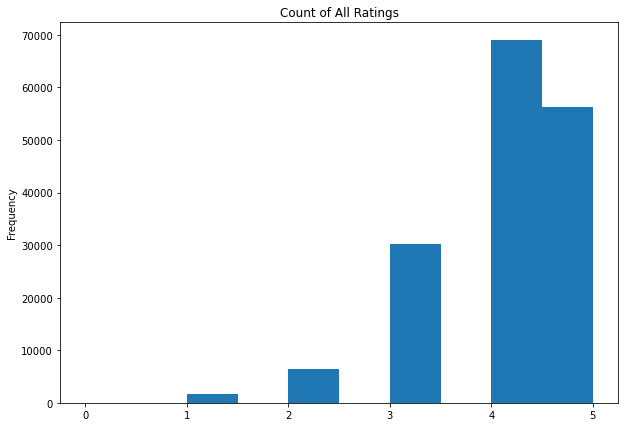

In [125]:
pd.Series([d["rating"] for d in data_CA5]).plot(
    kind="hist",
    title="Count of All Ratings",
    figsize=(10,7))
pd.Series([d["rating"] for d in data_CA5]).value_counts()

# **EDA #1: Distributions of Ratings by time of day (David)**

In [14]:
count = 0
lst = set()
for d in data_CA5:
    if type(d['unixReviewTime']) != int:
        count +=1
        lst.add(d['unixReviewTime'])
print(count,lst)

# might need to remove missing datetimes for the entire analysis: 
# 13,249 missing datetimes in data_CA5
# 5,280 missing datetimes in data_CA10
ratingsTime_5 = []
for d in data_CA5:
    if d['unixReviewTime'] != None:
        t = datetime.datetime.fromtimestamp(d['unixReviewTime'])
        ratingsTime_5.append((t,d['rating']))
ratingsTime_5.sort()
len(ratingsTime_5)

13249 {None}


150159

In [15]:
ratingsTimesOfDay = []
for t,r in ratingsTime_5:
    ratingsTimesOfDay.append((t.hour,t.minute,r))
ratingsTimesOfDay.sort()

In [16]:
tenMinInts = defaultdict(list)
fifteenMinInts = defaultdict(list)
hourlyInts = defaultdict(list)
hour = 0
for h,m,r in ratingsTimesOfDay:
    if h == hour:
        for minute in [10,20,30,40,50,60]:
            if m in [i for i in range(0+minute-10,minute)]:
                tenMinInts[h,minute-10].append(r)
        for minute in [15,30,45,60]:
            if m in [i for i in range(0+minute-15,minute)]:
                fifteenMinInts[h,minute-15].append(r)
        hourlyInts[h].append(r)
    hour = h
tenMinIntKeys = [h*60+m for h,m in list(tenMinInts.keys())]
fifteenMinIntKeys = [h*60+m for h,m in list(fifteenMinInts.keys())]
hourlyIntKeys = [h for h in list(hourlyInts.keys())]
#print(tenMinIntKeys)
tenMinAvgs = []
fifteenMinAvgs = []
hourlyAvgs = []
for key in tenMinInts:
    tenMinAvgs.append(np.mean(tenMinInts[key]))
for key in fifteenMinInts:
    fifteenMinAvgs.append(np.mean(fifteenMinInts[key]))
for key in hourlyInts:
    hourlyAvgs.append(np.mean(hourlyInts[key]))
print('10 min ints: ',min(tenMinAvgs),max(tenMinAvgs))
print('15 min ints: ',min(fifteenMinAvgs),max(fifteenMinAvgs))
print('hourly ints: ',min(hourlyAvgs),max(hourlyAvgs))
#print(tenMinAvgs)

10 min ints:  3.7801047120418847 4.328571428571428
15 min ints:  3.8151260504201683 4.209756097560976
hourly ints:  3.911318553092182 4.167906662157592


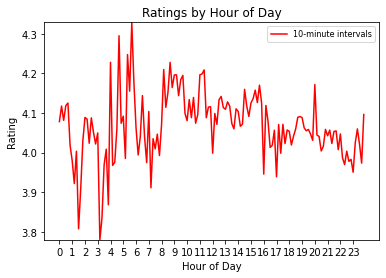

In [17]:
plt.plot(tenMinIntKeys,tenMinAvgs,label='10-minute intervals',color='red')
plt.xticks(tenMinIntKeys[::6], [int(x/60) for x in tenMinIntKeys[::6]])
plt.ylim(min(tenMinAvgs),max(tenMinAvgs))
plt.ylabel("Rating")
plt.xlabel("Hour of Day")
plt.legend(loc="best",fontsize=8)
plt.title("Ratings by Hour of Day")
plt.show()

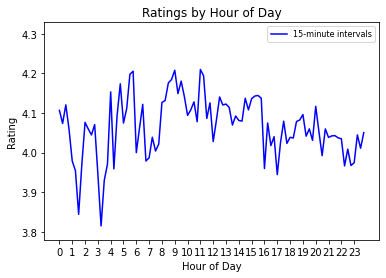

In [18]:
plt.plot(fifteenMinIntKeys,fifteenMinAvgs,label='15-minute intervals',color='blue')
plt.xticks(tenMinIntKeys[::6], [int(x/60) for x in tenMinIntKeys[::6]])
plt.ylim(min(tenMinAvgs),max(tenMinAvgs))
plt.ylabel("Rating")
plt.xlabel("Hour of Day")
plt.legend(loc="best",fontsize=8)
plt.title("Ratings by Hour of Day")
plt.show()

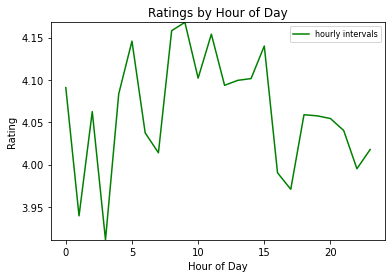

In [19]:
plt.plot(hourlyIntKeys,hourlyAvgs,label='hourly intervals',color='green')
#plt.xticks(tenMinIntKeys[::6], [int(x/60) for x in tenMinIntKeys[::6]])
plt.ylim(min(hourlyAvgs),max(hourlyAvgs))
plt.ylabel("Rating")
plt.xlabel("Hour of Day")
plt.legend(loc="best",fontsize=8)
plt.title("Ratings by Hour of Day")
plt.show()

# **EDA #2: Distribution of Ratings across years/months (David)**

In [20]:
# might need to remove missing datetimes for the entire analysis: 
# 13,249 missing datetimes in data_CA5
# 5,280 missing datetimes in data_CA10

# using the same ratingsTime_5 list as Distribution of Ratings for time of day EDA

In [21]:
wSize = 4000
x = [r[0] for r in ratingsTime_5] # as raw times
y = [r[1] for r in ratingsTime_5] # ratings
xu = [time.mktime(d.timetuple()) for d in x] # as unix times

In [22]:
xSum = sum(xu[:wSize])
ySum = sum(y[:wSize])
sliding = []

In [23]:
for i in range(wSize,len(x)-1):
    xSum += xu[i] - xu[i-wSize]
    ySum += y[i] - y[i-wSize]
    sliding.append((xSum*1.0/wSize,ySum*1.0/wSize))

In [24]:
X = [a[0] for a in sliding]
Y = [a[1] for a in sliding]

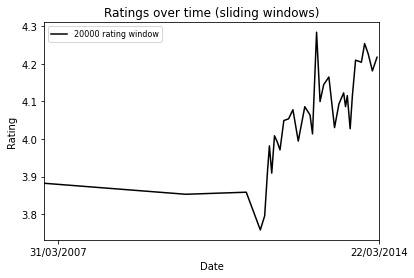

In [25]:
#remove outlier?
plt.plot(X[::4000],Y[::4000], label="20000 rating window", color='k')
plt.xticks([X[100], X[-350]], [x[wSize+100].strftime("%d/%m/%Y"), x[-350].strftime("%d/%m/%Y")])
plt.xlim(X[0], X[-1])
plt.ylabel("Rating")
plt.xlabel("Date")
plt.legend(loc="best",fontsize=8)
plt.title("Ratings over time (sliding windows)")
plt.show()

# **EDA #3: Categories of Businesses (Andrew)**<br />
can you look into building a popularity feature for categories?

In [127]:
cats = defaultdict(list)
for d in data_CA5:
    if d['categories']:
        for c in d['categories']:
            cats[c].append(d['rating'])
    else:
        cats["None"].append(d['rating'])

In [128]:
cat = [[c, len(cats[c]), np.mean(cats[c])] for c in cats]

<AxesSubplot:title={'center':'Histogram of Average Ratings per Category'}, ylabel='Frequency'>

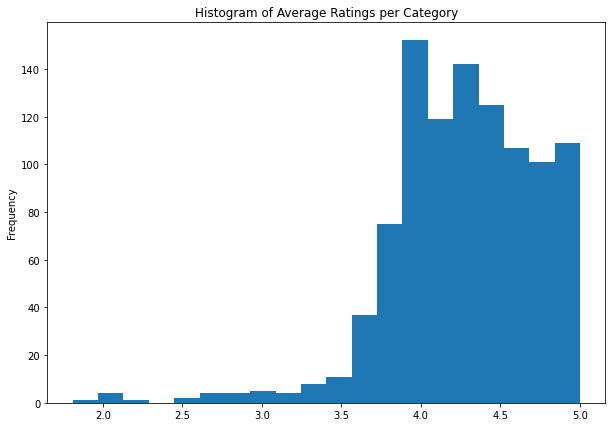

In [129]:
dfCats = pd.DataFrame(cat)
dfCats.sort_values(1, ascending=False).set_index(0)[2].plot(
    kind="hist", 
    title="Histogram of Average Ratings per Category",
    figsize=(10, 7),bins=20)

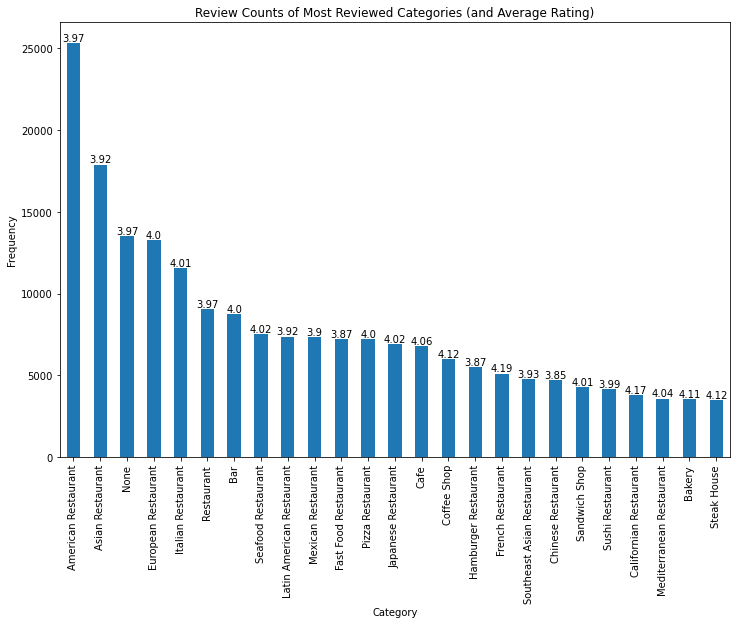

In [93]:
dfCatsCount = dfCats.sort_values(1, ascending=False)[:25].set_index(0)
plt.figure(figsize=(12, 8))
ax = dfCatsCount[1].plot(kind="bar")
ax.set_title("Review Counts of Most Reviewed Categories (and Average Rating)")
ax.set_xlabel("Category")
ax.set_ylabel("Frequency")

rects = ax.patches

# Make some labels.
labels = dfCatsCount[2].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )

plt.show()

<Figure size 432x288 with 0 Axes>

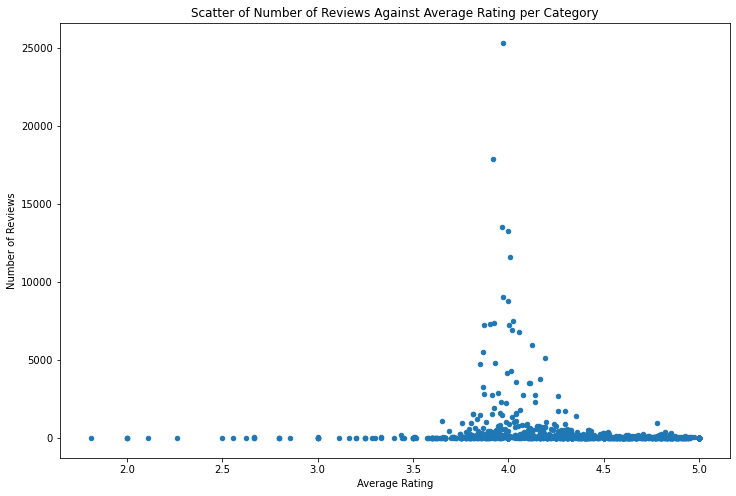

In [94]:
#All the top reviews were around 4, so this checks out
plt.figure()
ax = dfCats.set_index(0).plot(kind="scatter", x=2, y=1, figsize=(12, 8))
ax.set_title("Scatter of Number of Reviews Against Average Rating per Category")
ax.set_xlabel("Average Rating")
ax.set_ylabel("Number of Reviews")

plt.show()

# **EDA #4: Length of Reviews (Andrew)**

In [98]:
dfWords = pd.DataFrame([[len(d["reviewText"].split()), d["rating"]] for d in data_CA5 if d["reviewText"]], columns = ['words', 'rating'])

In [99]:
cats2 = defaultdict(list)
for d in data_CA5:
    if d['categories']:
        i = d['categories']
    else:
        i = ["None"]
    if d['reviewText']:
        w = len(d['reviewText'].split())
    else:
        w = 0
    for c in i:
        if c in cats2:
            cats2[c][0].append(d['rating'])
            cats2[c][1].append(w)
        else:
            cats2[c].append([d['rating']])
            cats2[c].append([w])

In [100]:
c2 = [(c, len(cats2[c][0]), np.mean(cats2[c][0]), np.mean(cats2[c][1])) for c in cats]

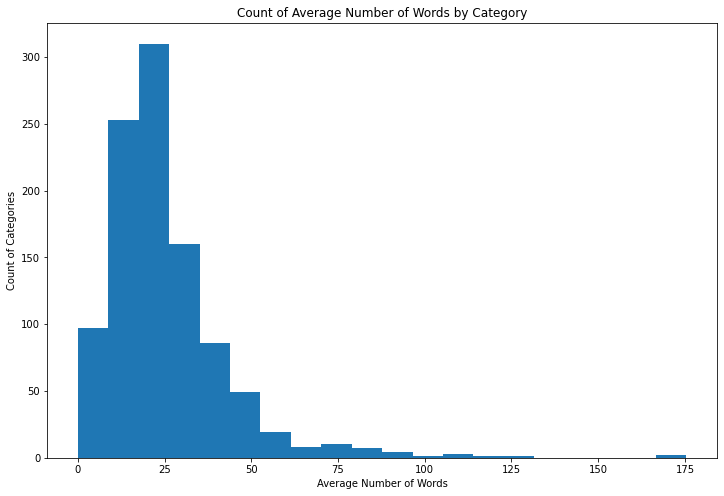

In [130]:
#All the top reviews were around 4, so this checks out
plt.figure()
ax = pd.DataFrame(c2).sort_values(3, ascending=False).set_index(0)[3].plot(kind="hist", figsize=(12, 8),bins=20)
ax.set_title("Count of Average Number of Words by Category")
ax.set_xlabel("Average Number of Words")
ax.set_ylabel("Count of Categories")

plt.show()

<AxesSubplot:title={'center':'Count of Number of Words in All Reviews'}, ylabel='Frequency'>

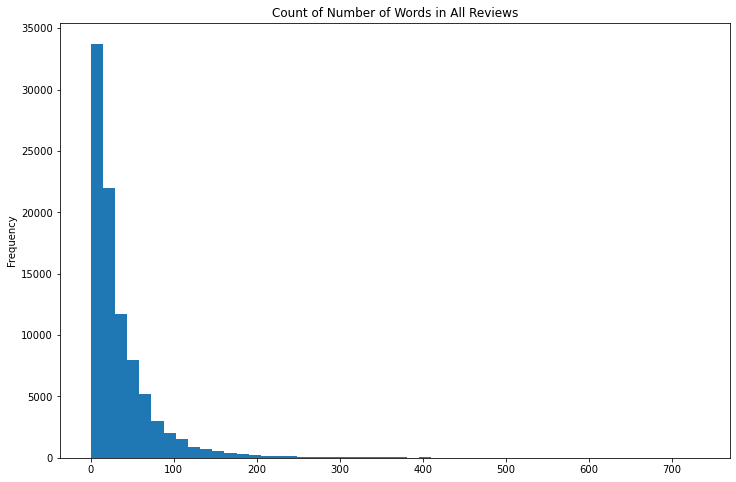

In [102]:
#Count of all words binned
#might not use this
dfWords["words"].plot(kind="hist", bins=50, figsize=(12,8), title="Count of Number of Words in All Reviews")

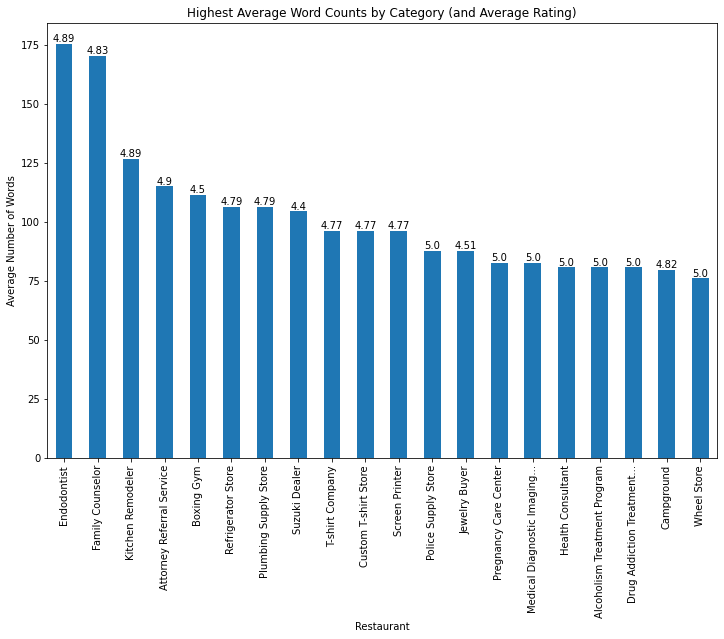

In [103]:
topAvgWords = pd.DataFrame(c2).sort_values(3, ascending=False)[:20].set_index(0)
plt.figure(figsize=(12, 8))
ax = topAvgWords[3].plot(kind="bar")
ax.set_title("Highest Average Word Counts by Category (and Average Rating)")
ax.set_xlabel("Restaurant")
ax.set_ylabel("Average Number of Words")

rects = ax.patches

# Make some labels.
labels = topAvgWords[2].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
    )

plt.show()

<Figure size 432x288 with 0 Axes>

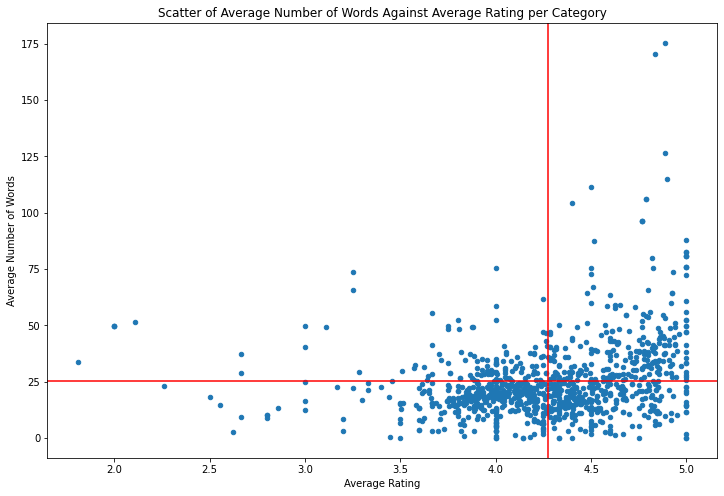

In [142]:
#All the top ratings were around 5, so this checks out
plt.figure()
dfWordsRating = pd.DataFrame(c2)
ax = dfWordsRating.set_index(0).plot(kind="scatter", x=2, y=3, figsize=(12, 8))
ax.set_title("Scatter of Average Number of Words Against Average Rating per Category")
ax.set_xlabel("Average Rating")
ax.set_ylabel("Average Number of Words")

plt.axhline(y=pd.DataFrame(c2).mean()[3], color='r', linestyle='-') 
plt.axvline(x=pd.DataFrame(c2).mean()[2], color='r', linestyle='-') 



plt.show()

# Train-Validation-Test Split (70%-20%-10%)

In [26]:
X=[]
y=[]
for rowDict in data_CA5:
    data = []
    for key in rowDict:
        if key == 'rating':
            y.append(rowDict[key])
        else:
            data.append(rowDict[key])
    X.append(data)

In [131]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=(10/30))
print(len(X_train),len(X_val),len(X_test))

114385 32682 16341


# **Trivial Model (1): Predict the Global Average from Train**

In [106]:
ratingsGlobalAvg = np.mean(y_train)
ratingsGlobalAvg

4.049569269877136

In [109]:
print("MSE: ", str(np.mean(((y_test-ratingsGlobalAvg)**2))))
print("MAE: ", str(np.mean(abs((y_test-ratingsGlobalAvg)))))

MSE:  0.7701002669528957
MAE:  0.6525152937032613


# **Simple Baseline Model (2): Weighted Average Using Ratings**

In [ ]:
#Calculate Category Averages
cats = defaultdict(list)
for i in range(len(X_train)):
    d = X_train[i]
    #print(d)
    if d[2]:
        for c in d[2]:
            cats[c].append(y_train[i])
    else:
        cats["None"].append(y_train[i])
    
ratingsCatAvg = {c: np.mean(cats[c]) for c in cats}
ratingsCatAvg

In [122]:
preds = [np.mean([ratingsCatAvg[c] if c in ratingsCatAvg else ratingsCatAvg['None'] for c in d[2]])
        if d[2] else ratingsCatAvg['None']
        for d in X_test]

<Figure size 432x288 with 0 Axes>

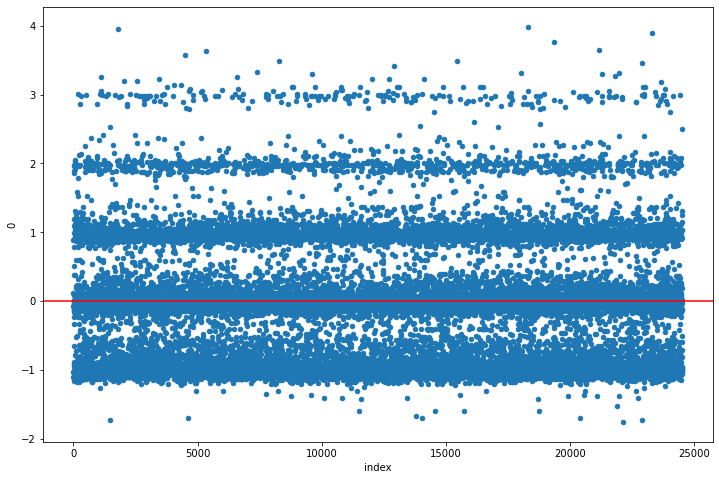

In [123]:
#Calculating error
errors = (pd.Series(preds) - pd.Series(y_test))
#Comparing estimate to true values
plt.figure()
ax = errors.to_frame().reset_index().plot(kind="scatter", x="index", y=0, figsize=(12, 8))
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [124]:
print("MSE: ", str((errors**2).mean()))
print("MAE: ", str(abs(errors).mean()))

MSE:  0.7301281355229067
MAE:  0.6373771167053162


# **Baseline Model (3): ?**

**Location Based Social Networks?**<br />
(David)

**Temporal Dynamics Feature**<br />
(David)<br />
Tensorflow FPMC model

In [29]:
interactions=[]
interactionsPerUser=defaultdict(list)
userIDs={}
itemIDs={}
for d in data_CA5:
    user = d['gPlusUserId']
    if user == None: continue
    business = d['gPlusPlaceId']
    if business == None: continue
    time = d['unixReviewTime']
    if time == None: continue
    rating = d['rating']
    if not user in userIDs: userIDs[user] = len(userIDs)
    if not business in itemIDs: itemIDs[business] = len(itemIDs)
    interactionsPerUser[user].append([time,business,rating])
    interactions.append((time,user,business,rating))

In [30]:
interactionsWithPrevious = []
for user in interactionsPerUser:
    interactionsPerUser[user].sort()
    lastItem = 'dummy'
    for t,i,r in interactionsPerUser[user]:
        interactionsWithPrevious.append([t,user,i,lastItem,r])
        lastItem=i

In [ ]:
interactionsWithPrevious

In [32]:
itemsPerUser = defaultdict(set)
for _,u,i,_ in interactions:
    itemsPerUser[u].add(i)

In [33]:
items = list(itemIDs.keys())
itemIDs['dummy'] = len(itemIDs)

In [34]:
class FPMC(tf.keras.Model):
    def __init__(self, K, lamb, UI = 1, IJ = 1):
        super(FPMC, self).__init__()
        # Initialize variables
        self.betaI = tf.Variable(tf.random.normal([len(itemIDs)],stddev=0.001))
        self.gammaUI = tf.Variable(tf.random.normal([len(userIDs),K],stddev=0.001))
        self.gammaIU = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        self.gammaIJ = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        self.gammaJI = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        # Regularization coefficient
        self.lamb = lamb
        # Which terms to include
        self.UI = UI
        self.IJ = IJ

    # Prediction for a single instance
    def predict(self, u, i, j):
        p = self.betaI[i] + self.UI * tf.tensordot(self.gammaUI[u], self.gammaIU[i], 1) +\
                            self.IJ * tf.tensordot(self.gammaIJ[i], self.gammaJI[j], 1)
        return p

    # Regularizer
    def reg(self):
        return self.lamb * (tf.nn.l2_loss(self.betaI) +\
                            tf.nn.l2_loss(self.gammaUI) +\
                            tf.nn.l2_loss(self.gammaIU) +\
                            tf.nn.l2_loss(self.gammaIJ) +\
                            tf.nn.l2_loss(self.gammaJI))

    def call(self, sampleU, # user
                   sampleI, # item
                   sampleJ, # previous item
                   sampleK): # negative item
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        j = tf.convert_to_tensor(sampleJ, dtype=tf.int32)
        k = tf.convert_to_tensor(sampleK, dtype=tf.int32)
        gamma_ui = tf.nn.embedding_lookup(self.gammaUI, u)
        gamma_iu = tf.nn.embedding_lookup(self.gammaIU, i)
        gamma_ij = tf.nn.embedding_lookup(self.gammaIJ, i)
        gamma_ji = tf.nn.embedding_lookup(self.gammaJI, j)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        x_uij = beta_i + self.UI * tf.reduce_sum(tf.multiply(gamma_ui, gamma_iu), 1) +\
                         self.IJ * tf.reduce_sum(tf.multiply(gamma_ij, gamma_ji), 1)
        gamma_uk = tf.nn.embedding_lookup(self.gammaUI, u)
        gamma_ku = tf.nn.embedding_lookup(self.gammaIU, k)
        gamma_kj = tf.nn.embedding_lookup(self.gammaIJ, k)
        gamma_jk = tf.nn.embedding_lookup(self.gammaJI, j)
        beta_k = tf.nn.embedding_lookup(self.betaI, k)
        x_ukj = beta_k + self.UI * tf.reduce_sum(tf.multiply(gamma_uk, gamma_ku), 1) +\
                         self.IJ * tf.reduce_sum(tf.multiply(gamma_kj, gamma_jk), 1)
        return -tf.reduce_mean(tf.math.log(tf.math.sigmoid(x_uij - x_ukj)))

In [35]:
def trainingStep(model, interactions):
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleJ, sampleK = [], [], [], []
        for _ in range(100000):
            _,u,i,j,_ = random.choice(interactions) # positive sample from training set only
            k = random.choice(items) # negative sample from training set only
            while k in itemsPerUser[u]:
                k = random.choice(items)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[i])
            sampleJ.append(itemIDs[j])
            sampleK.append(itemIDs[k])

        loss = model(sampleU,sampleI,sampleJ,sampleK)
        loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()

In [36]:
optimizer = tf.keras.optimizers.Adam(0.1)
modelFPMC = FPMC(5, 0.001, 1, 1)

In [37]:
data_CA5[0].keys()

dict_keys(['rating', 'reviewerName', 'reviewText', 'categories', 'gPlusPlaceId', 'unixReviewTime', 'reviewTime', 'gPlusUserId'])

In [38]:
X_trainFPMC = []
y_trainFPMC = []
for i in range(len(X_train)):
    d = X_train[i]
    r = y_train[i]
    if d[4] != None: 
        X_trainFPMC.append(d)
        y_trainFPMC.append(r)

X_valFPMC = []
y_valFPMC = []
for i in range(len(X_val)):
    d = X_val[i]
    r = y_val[i]
    if d[4] != None: 
        X_valFPMC.append(d)
        y_valFPMC.append(r)
        
X_testFPMC = []
y_testFPMC = []
for i in range(len(X_test)):
    d = X_test[i]
    r = y_test[i]
    if d[4] != None: 
        X_testFPMC.append(d)
        y_testFPMC.append(r)

In [39]:
trainFPMC = defaultdict(list)
valFPMC = defaultdict(list)
testFPMC = defaultdict(list)
for i in range(len(X_trainFPMC)):
    d = X_trainFPMC[i]
    trainFPMC[d[6]].append([d[4],d[3],y_trainFPMC[i]]) #time,business,rating
for i in range(len(X_valFPMC)):
    d = X_valFPMC[i]
    valFPMC[d[6]].append([d[4],d[3],y_valFPMC[i]])
for i in range(len(X_testFPMC)):
    d = X_testFPMC[i]
    testFPMC[d[6]].append([d[4],d[3],y_testFPMC[i]])

In [40]:
interactionsWithPreviousTrain = []

for user in trainFPMC:
    trainFPMC[user].sort()
    lastItem = 'dummy'
    for t,i,r in trainFPMC[user]:
        interactionsWithPreviousTrain.append([t,user,i,lastItem,r])
        lastItem = i

In [41]:
interactionsWithPreviousVal = []
for user in valFPMC:
    valFPMC[user].sort()
    lastItem = 'dummy'
    for t,i,r in valFPMC[user]:
        interactionsWithPreviousVal.append([t,user,i,lastItem,r])
        lastItem = i

In [42]:
testFPMC['104328546195224662053']

[[1375644327, '103735859121733351539', 4.0]]

In [43]:
interactionsPrevTest = []
for user in testFPMC:
    testFPMC[user].sort()
    lastItem = 'dummy'
    for t,i,r in testFPMC[user]:
        interactionsPrevTest.append([t,user,i,lastItem,r])
        lastItem = i

In [50]:
interactionsValPerUser = defaultdict(set)
itemSet = set()
for _,u,i,j,_ in interactionsWithPreviousVal:
    interactionsValPerUser[u].add((i,j))
    itemSet.add(i)
    itemSet.add(j)

In [51]:
def AUCu(model, u, N):
    win = 0
    if N > len(interactionsValPerUser[u]):
        N = len(interactionsValPerUser[u])
    positive = random.sample(interactionsValPerUser[u],N)
    negative = random.sample(itemSet,N)
    for (i,j),k in zip(positive,negative):
        sp = model.predict(userIDs[u], itemIDs[i], itemIDs[j]).numpy()
        sn = model.predict(userIDs[u], itemIDs[k], itemIDs[j]).numpy()
        if sp > sn:
            win += 1
    return win/N

In [52]:
def AUC(model):
    av = []
    for u in interactionsValPerUser:
        av.append(AUCu(model, u, 10))
    return sum(av) / len(av)

In [54]:
#model selection for FPMC
bestModel = None
bestAUC = 0
for K in [1,2,3,4,5]:
    optimizer = tf.keras.optimizers.Adam(0.1)
    modelFPMC = FPMC(K, 0.001, 1, 1)
    for i in range(100):
        obj = trainingStep(modelFPMC, interactionsWithPreviousTrain)
        if (i % 10 == 9): print("iteration " + str(i+1) + ", objective = " + str(obj))
    modelAUC = AUC(modelFPMC)
    print("K = "+str(K)+", AUC = " + str(modelAUC))
    if bestModel == None or bestAUC < modelAUC:
        bestModel = modelFPMC
        bestAUC = modelAUC

iteration 10, objective = 0.6887863
iteration 20, objective = 0.68191093
iteration 30, objective = 0.6787128
iteration 40, objective = 0.67817056
iteration 50, objective = 0.6783022
iteration 60, objective = 0.6775372
iteration 70, objective = 0.6776922
iteration 80, objective = 0.67798245
iteration 90, objective = 0.6777612
iteration 100, objective = 0.6776713
K = 1, AUC = 0.6442913477151461
iteration 10, objective = 0.6936625
iteration 20, objective = 0.6850348
iteration 30, objective = 0.67904246
iteration 40, objective = 0.6787648
iteration 50, objective = 0.67834073
iteration 60, objective = 0.6777238
iteration 70, objective = 0.6778073
iteration 80, objective = 0.67762274
iteration 90, objective = 0.6782007
iteration 100, objective = 0.67758656
K = 2, AUC = 0.6505204846958497
iteration 10, objective = 0.698682
iteration 20, objective = 0.6880115
iteration 30, objective = 0.6794269
iteration 40, objective = 0.6786953
iteration 50, objective = 0.677982
iteration 60, objective = 0.6

In [56]:
interactionsTestPerUser = defaultdict(set)
itemSet = set()
for _,u,i,j,_ in interactionsPrevTest:
    interactionsTestPerUser[u].add((i,j))
    itemSet.add(i)
    itemSet.add(j)

In [134]:
def AUCu(model, u, N):
    win = 0
    if N > len(interactionsTestPerUser[u]):
        N = len(interactionsTestPerUser[u])
    positive = random.sample(interactionsTestPerUser[u],N)
    negative = random.sample(itemSet,N)
    for (i,j),k in zip(positive,negative):
        sp = model.predict(userIDs[u], itemIDs[i], itemIDs[j]).numpy()
        print(sp)
        sn = model.predict(userIDs[u], itemIDs[k], itemIDs[j]).numpy()
        if sp > sn:
            win += 1
        break
    return win/N

In [135]:
def AUC(model):
    av = []
    for u in interactionsTestPerUser:
        av.append(AUCu(model, u, 10))
    return sum(av) / len(av)

In [61]:
print("AUC = " + str(AUC(bestModel)))

AUC = 0.637560556675747


Best FPMC Model from model selection step was K = 2 for Validation Data with AUC = 0.6505<br />
Got the AUC from the Test Data using the best model from the model selection: AUC = 0.6376

**Price?**<br />
(Andrew)<br />
One-Hot Encoding

In [67]:
#Setup price for each businessID
priceKey = defaultdict(str)
for d in places_CA:
    if d['price'] == None:
        priceKey[d["gPlusPlaceId"]] = ""
    else:
        priceKey[d["gPlusPlaceId"]] = d['price']

In [68]:
uniquePrice = ['','$','$$','$$$']
catID = dict(zip(uniquePrice,range(len(uniquePrice))))
print(catID)

{'': 0, '$': 1, '$$': 2, '$$$': 3}


In [71]:
def featPrice(d):
    businessID = d[3]
    price = priceKey[businessID]
    feat = [0]*len(catID)
    if price in catID:
        feat[catID[price]] = 1
    
    return feat

In [72]:
featPrice(X_train[0])

[0, 0, 0, 1]

**Text Analysis?**<br />
(Maricela)<br />
TfIdf?

**Cosine Feature**<br />
(Andrew)

In [49]:
#Train-Validation-Validation (65%-20%-15%)
#compare MSE, look into F1?, or other model measurements

Linear Regression Model<br />
Decision Tree Regression/Classification<br />
SVD<br />
K-Nearest Neighbors<br />
Other Models?

Evaluating Overfitting<br />
test on both CA_5 and CA_10